<a href="https://colab.research.google.com/github/daspartho/MagicMix/blob/main/MagicMIx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 503 kB 4.5 MB/s 
     |████████████████████████████████| 5.8 MB 74.8 MB/s 
     |████████████████████████████████| 191 kB 57.7 MB/s 
     |████████████████████████████████| 182 kB 66.3 MB/s 
     |████████████████████████████████| 7.6 MB 32.1 MB/s 


In [2]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer, logging
import torch
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from PIL import Image
from IPython import display

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
).to(device)

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
).to(device)

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
).to(device)

beta_start,beta_end = 0.00085,0.012
scheduler = DDIMScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False, 
    set_alpha_to_one=False,
)

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [4]:
def encode(img):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(img).unsqueeze(0).to(device)*2-1)
        latent = 0.18215 * latent.latent_dist.sample()
    return latent

def show_img(img):
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    display.display(Image.fromarray(img[0]))

In [5]:
def prep_text(prompt):

    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embedding = text_encoder(
        text_input.input_ids.to(device)
    )[0]

    uncond_input = tokenizer(
        "",
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    uncond_embedding = text_encoder(
        uncond_input.input_ids.to(device)
    )[0]

    return torch.cat([uncond_embedding, text_embedding])

In [6]:
!curl --output test.jpg 'https://images.unsplash.com/photo-1565277441243-2be39689f95b?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1929&q=80'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  511k  100  511k    0     0  2347k      0 --:--:-- --:--:-- --:--:-- 2347k


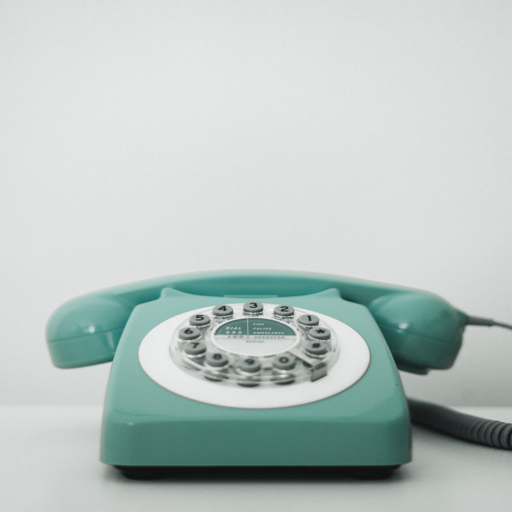

In [7]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

  0%|          | 0/50 [00:00<?, ?it/s]

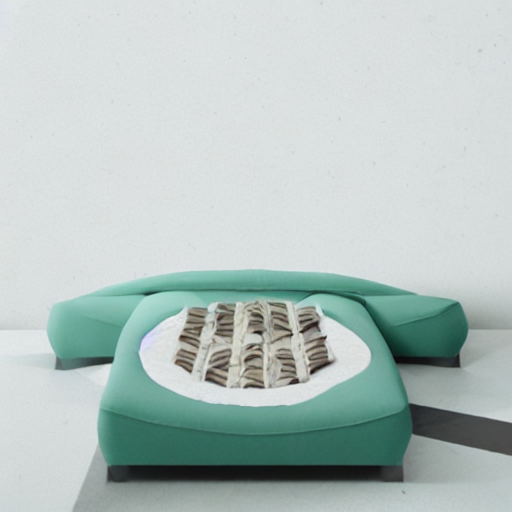

In [8]:
prompt = 'bed'
steps=50
kmin=40
kmax=25
seed=42
guidance_scale=7.5
v=0.75

text_embeddings = prep_text(prompt)

scheduler.set_timesteps(steps)

width, height = img.size
encoded = encode(img)

torch.manual_seed(seed)
noise = torch.randn(
    (1,unet.in_channels,height // 8,width // 8),
).to(device)

latents = scheduler.add_noise(
    encoded, 
    noise, 
    timesteps=scheduler.timesteps[kmax]
)

for i, t in enumerate(tqdm(scheduler.timesteps)):
    if i > kmax:
        if i < kmin:
            orig_latents = scheduler.add_noise(
                encoded, 
                noise, 
                timesteps=t
            )
            
            input = (v*latents) + (1-v)*orig_latents
            input = torch.cat([input]*2)

        else:
            input = torch.cat([latents]*2)
            
        input = scheduler.scale_model_input(input, t)

        with torch.no_grad():
            pred = unet(
                input, 
                t,
                encoder_hidden_states=text_embeddings,
            ).sample

        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        latents = scheduler.step(pred, t, latents).prev_sample

latents = (1 / 0.18215) * latents
with torch.no_grad():
    out_img = vae.decode(latents).sample

show_img(out_img)